# Roles Classifier Alternative: K-Nearest Neighbor

Imports and downloading tokenizers from NLTK:

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

## Testing Several Files

In [15]:
file_size = [150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 645]
accuracy = []

for i in file_size:
    file_name = f'output/balanced_{i}.csv'
    roles = pd.read_csv(f'../{file_name}')
    mapping = {'Student': 0, 'Co-Facilitator': 1, 'Facilitator': 2}
    roles['Role'] = roles['Role'].apply(lambda x: mapping[x])

    X = roles['Text']
    y = roles['Role']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

    knn = KNeighborsClassifier(n_neighbors=1)
    knn_classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', knn),
    ])

    # Fitting our train data to the pipeline
    knn_classifier.fit(X_train, y_train)
    predicted = knn_classifier.predict(X_valid)

    accuracy_partial = np.mean(predicted == y_valid)
    print(f'Accuracy for file_size {i}: %.3f' % accuracy_partial)
    accuracy.append(accuracy_partial)

Accuracy for file_size 150: 0.400
Accuracy for file_size 200: 0.400
Accuracy for file_size 250: 0.360
Accuracy for file_size 300: 0.533
Accuracy for file_size 350: 0.414
Accuracy for file_size 400: 0.425
Accuracy for file_size 450: 0.444
Accuracy for file_size 500: 0.540
Accuracy for file_size 550: 0.391
Accuracy for file_size 600: 0.450
Accuracy for file_size 645: 0.457


## Graphical Performance Analysis

In the following plots we can see the how the model behaves when it is trained with different amounts of data.

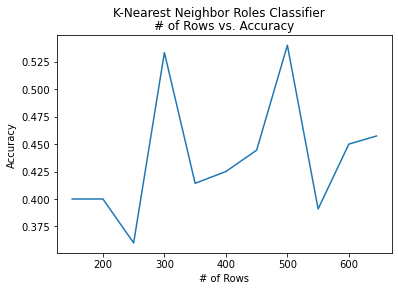

In [16]:
%matplotlib inline

plt.plot(file_size, accuracy)
plt.title('# of Rows vs. Accuracy')
plt.suptitle('K-Nearest Neighbor Roles Classifier')
plt.xlabel('# of Rows')
plt.ylabel('Accuracy')
plt.show()

## Conclusions

- The model doesn't show a good performance with the datasets, and we can see that the behavior is random, from which we
can conclude that KNN was not able to learn anything from the datasets.